In [13]:
from ete3 import PhyloTree
from collections import Counter
import pandas as pd, glob
import seaborn as sns
from pylab import subplots, show

In [2]:
tree101 = PhyloTree('../data/trees/ALIASES_NEWICK_101g_nucl_conc_28bfossils.combined.tre') # Zuza

In [ ]:
# Getting number of elements of each kind from RepeatMasker out files:
data = {}
for f in glob.glob('../data/RepeatMaskerOut/*out'):
    fish = f.split('/')[-1].split('.')[0]
    if fish == 'Final_PilonAsm_ssalBroken':
        fish = 'fish_145'
        
    fh = open(f, 'r')
    out = fh.readlines()
    fh.close()
    bp_covered = []
    repeats = []
    n_TEs = []
    for line in out[3:]:
        split = line.split()
        start = split[5]
        end = split[6]
        bp = int(end) - int(start)
        bp_covered.append(bp)
        repeat = split[10]
        repeats.append(repeat)
    data.update({fish : repeats})

In [4]:
data_dicts = {}
for key in data:
    data_dicts.update({key : Counter(data[key])})

# making dataframe
m = pd.DataFrame(data_dicts)

# saving as file
m.to_csv('../data/RepeatMaskerRawNumbers/superfamily_matrix.csv')

# metadata
fishinfo = pd.read_csv('../data/metadata/names.tab', sep = '\t')

# mapping alias to species
alias_species = dict(fishinfo.set_index('ALIAS')['SPECIES'])

# 101 names
leaf_names = tree101.get_leaf_names()

# ordering dataframe as they appear in the phylogeny
m = m[leaf_names]

# setting latin names
m.columns = [alias_species[x] for x in m.columns]

# extracting DNA transposons, LTR retrotransposons and LINEs
dna = m.filter(regex  = 'DNA/', axis = 0)
ltr = m.filter(regex  = 'LTR/', axis = 0)
line = m.filter(regex  = 'LINE/', axis = 0)

# merging
mall = pd.concat([dna, ltr, line])

Plotting

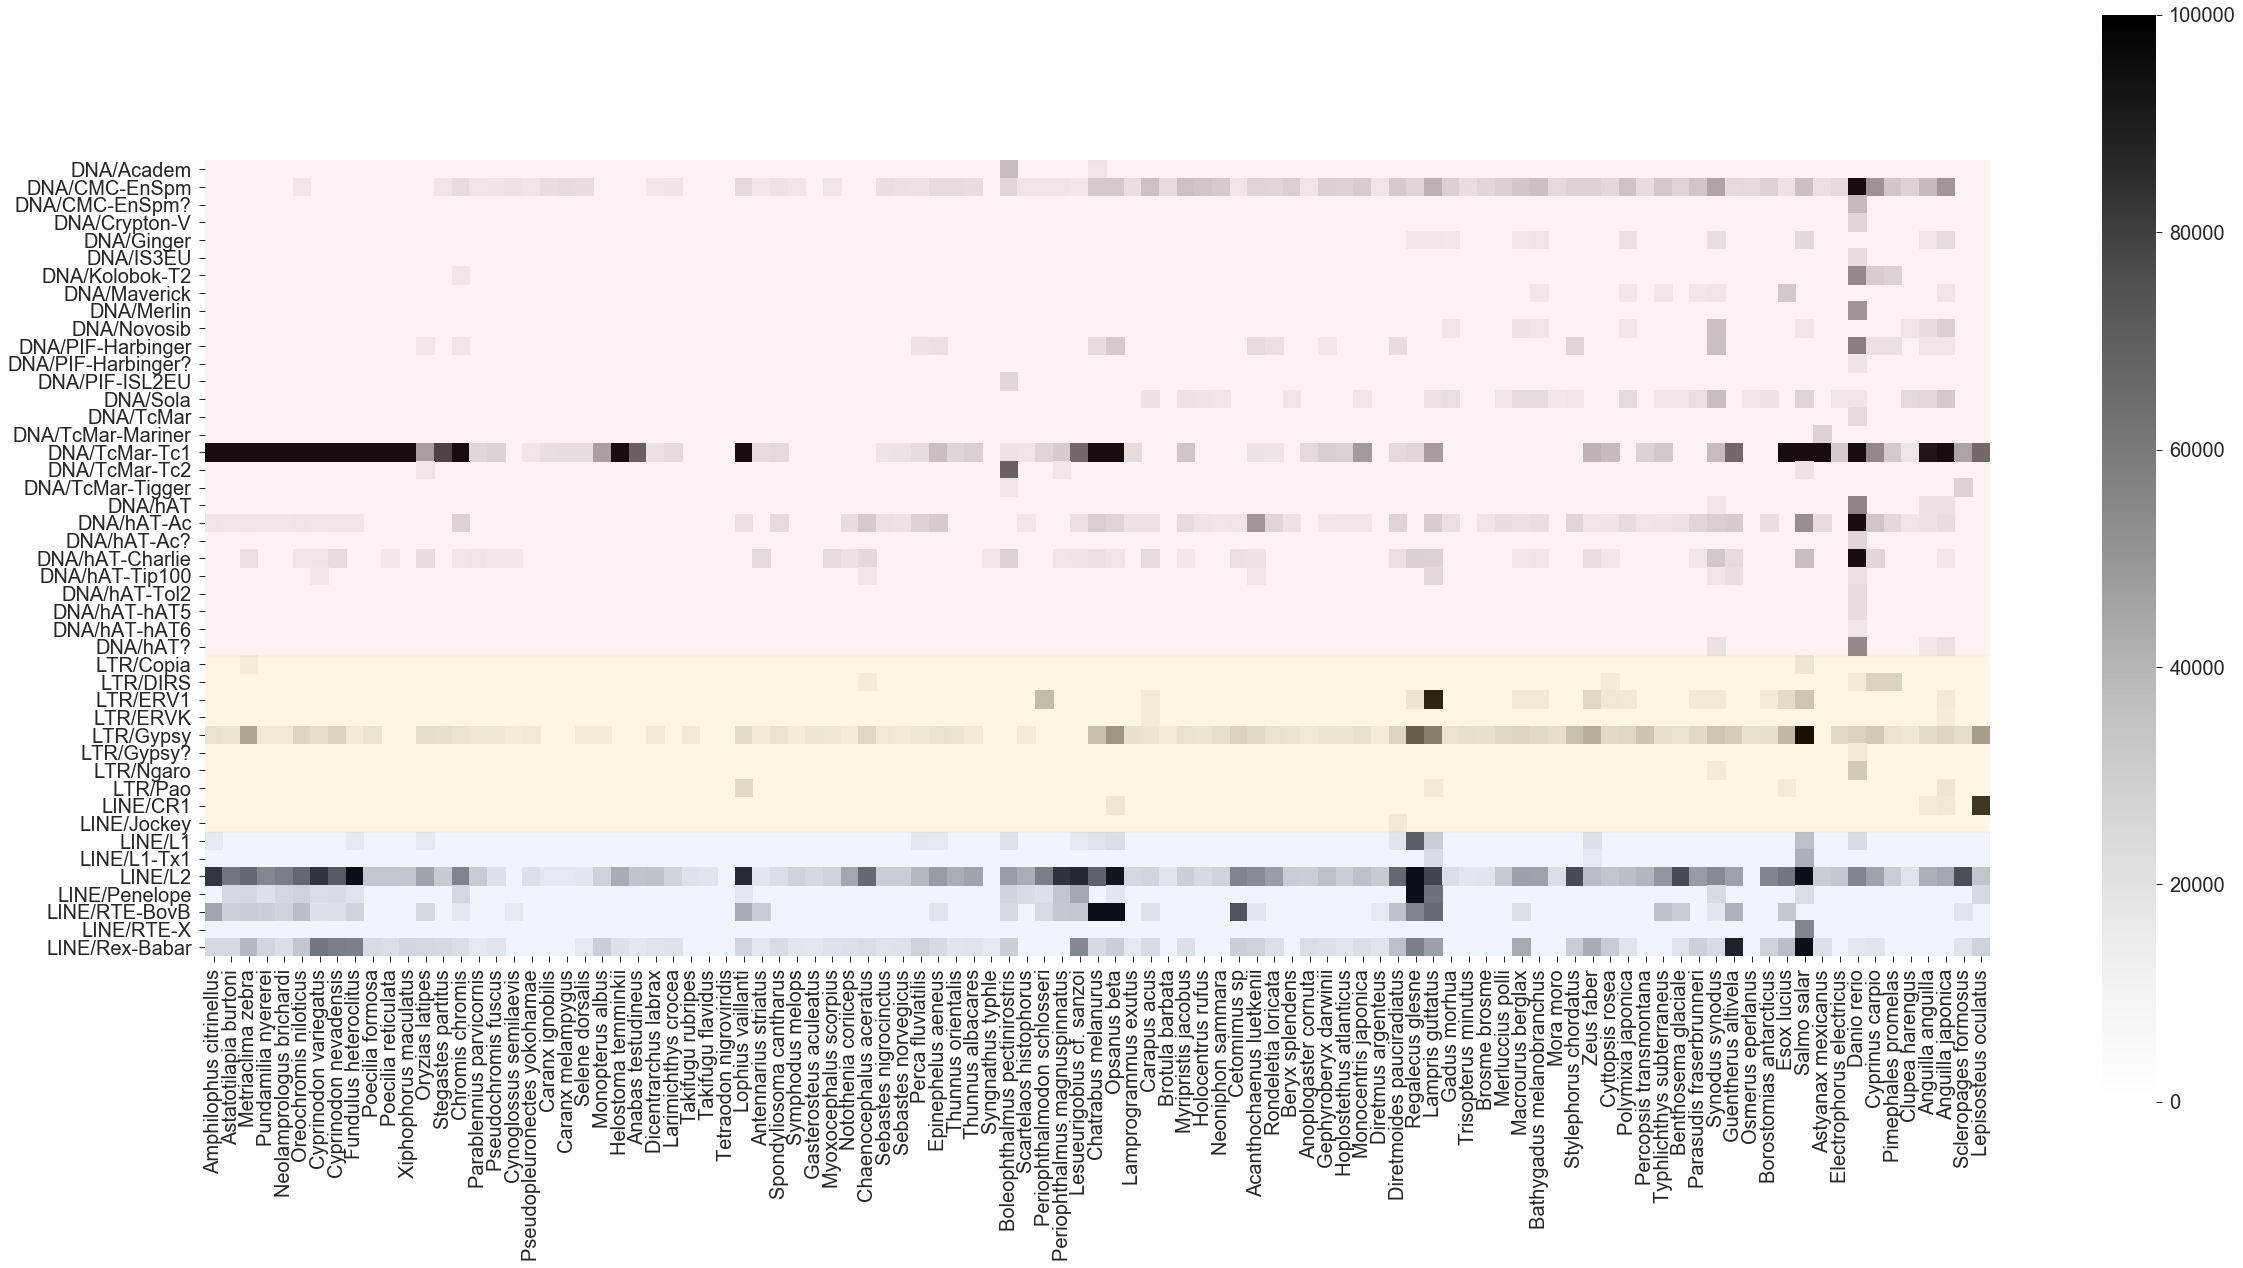

In [34]:
sns.set(font_scale=2, style = 'ticks')
f, ax = subplots(figsize = (40, 20))
d = mall.dropna().fillna(0)
d = d.mask(d.applymap(lambda x: x < 10000)).dropna(how = 'all').fillna(0)
sns.heatmap(d, vmax = 100000, vmin = 0, cmap = 'Greys', square = True, 
            mask = d.applymap(lambda x: x < 10000), xticklabels = True, cbar = True)
ax.axhspan(0, 28, color = 'lightcoral', alpha = 0.1)
ax.axhspan(28, 38, color = 'orange', alpha = 0.1)
ax.axhspan(38, 50, color = 'cornflowerblue', alpha = 0.1)
ax.yaxis.set_label_position("right")
show()